# cartpole环境
在车杆环境中，有一辆小车，智能体的任务是通过左右移动保持车上的杆竖直，若杆的倾斜度数过大，或者车子离初始位置左右的偏离程度过大，或者坚持时间到达 200 帧，则游戏结束。智能体的状态是一个维数为 4 的向量，每一维都是连续的，其动作是离散的，动作空间大小为 2，详情参见表 7-1 和表 7-2。在游戏中每坚持一帧，智能体能获得分数为 1 的奖励，坚持时间越长，则最后的分数越高，坚持 200 帧即可获得最高的分数。

![cart-pole](https://hrl.boyuai.com/static/cartpole.e4a03ca5.gif)
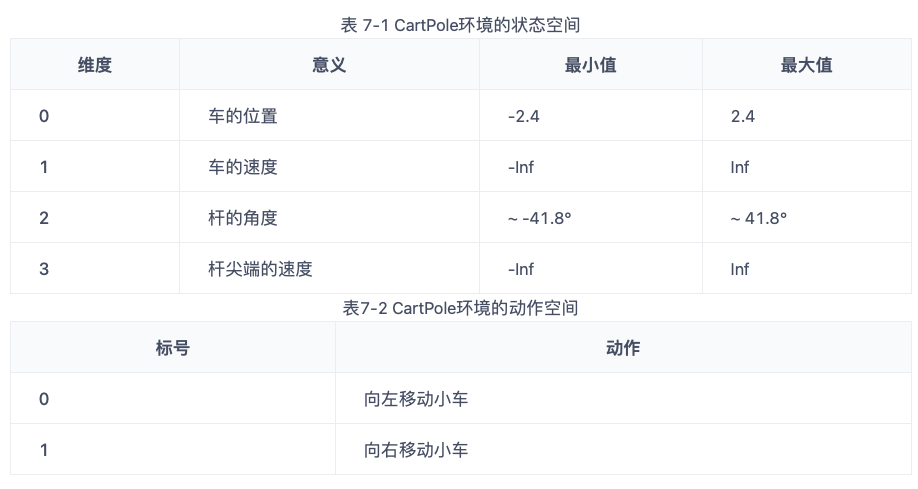

In [1]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

env_name = 'CartPole-v0'
env = gym.make(env_name, render_mode='rgb_array')
state= env.reset(seed=1)
# env_screen = np.array(env.render())[0]
# print(env_screen.shape)
n_states = env.observation_space.shape[0]
n_actions = env.action_space.n
print("Action Space {}".format(n_actions))
print("State Space {}".format(n_states))


/Users/dengsiyuan/opt/anaconda3/envs/regular/lib/python3.9/site-packages/gym/envs/registration.py:592: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/Users/dengsiyuan/opt/anaconda3/envs/regular/lib/python3.9/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/dengsiyuan/opt/anaconda3/envs/regular/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Action Space 2
State Space 4


# 设置动画显示


In [2]:
# 动画显示参考 http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/
from IPython.display import clear_output
from time import sleep
import matplotlib.animation as animation
from IPython.display import display, HTML
from matplotlib import animation, rc
from IPython.display import HTML


def plot_sequence_images(image_array):
    ''' Display images sequence as an animation in jupyter notebook

    Args:
        image_array(numpy.ndarray): image_array.shape equal to (num_images, height, width, num_channels)
    '''
    dpi = 72.0
    xpixels, ypixels = image_array[0].shape[:2]
    fig = plt.figure(figsize=(ypixels / dpi, xpixels / dpi), dpi=dpi)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)

    anim = animation.FuncAnimation(fig, animate, frames=len(
        image_array), interval=33, repeat_delay=1, repeat=False)
#     display(HTML(anim.to_html5_video()))
    #rc('animation', html='html5')
    return anim

#anim = plot_sequence_images(frames)
#rc('animation', html='html5')
# anim

# 设置模型参数并训练

In [3]:
import os 
import gym
import torch
import datetime
import numpy as np
import argparse
from rl_utils import ReplayBuffer
from dqn import DQN, MLP

# curr_path = os.path.dirname(os.path.abspath(__file__))  # current path
def get_args():
    """ hyperparameters
    """
    curr_time = datetime.datetime.now().strftime(
        "%Y%m%d-%H%M%S")  # obtain current time
    parser = argparse.ArgumentParser(description="hyperparameters")
    parser.add_argument('--algo_name', default='DQN',
                        type=str, help="name of algorithm")
    parser.add_argument('--env_name', default='CartPole-v1',
                        type=str, help="name of environment")
    parser.add_argument('--train_eps', default=500,
                        type=int, help="episodes of training")
    parser.add_argument('--test_eps', default=20, type=int,
                        help="episodes of testing")
    parser.add_argument('--gamma', default=0.95,
                        type=float, help="discounted factor")
    parser.add_argument('--epsilon', default=0.95,
                        type=float, help="initial value of epsilon")
    parser.add_argument('--epsilon_min', default=0.01,
                        type=float, help="final value of epsilon")
    parser.add_argument('--epsilon_decay', default=0.99, type=float,
                        help="decay rate of epsilon, the higher value, the slower decay")
    parser.add_argument('--lr', default=0.001,
                        type=float, help="learning rate")
    parser.add_argument('--memory_capacity', default=10000,
                        type=int, help="memory capacity")
    parser.add_argument('--min_memory', default=500, type=int, help="buffer超过这个值之后才开始更新网络")
    parser.add_argument('--batch_size', default=64, type=int)
    parser.add_argument('--target_update_interval', default=10, type=int)
    parser.add_argument('--hidden_dim', default=128, type=int)
    parser.add_argument('--device', default='cpu',
                        type=str, help="cpu or cuda")
    
    args = parser.parse_args([])
    return args


cfg = get_args()

In [4]:
cfg = get_args()
model = MLP(n_states, n_actions, hidden_dim=cfg.hidden_dim)
# memory = ReplayBuffer(cfg.memory_capacity)
agent = DQN(n_states, n_actions, learning_rate=cfg.lr, gamma=cfg.gamma,
            epsilon=cfg.epsilon, epsilon_decay=cfg.epsilon_decay, epsilon_min=cfg.epsilon_min,
            memory_size=cfg.memory_capacity, target_update_interval=cfg.target_update_interval,
            batch_size=cfg.batch_size, device=cfg.device, q_net=model)

![dqn psudocode](../img/dqn.png)

In [5]:
def train(env, agent, cfg):
    print("Training start")
    print(f"Env: {env_name}, Algorithm: {cfg.algo_name}, Device: {cfg.device}")
    rewards = []  # record rewards for all episodes
    steps = []
    for i_ep in range(cfg.train_eps):
        ep_reward = 0
        ep_step=0
        state = env.reset()
        done = False
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done,  _ = env.step(action)
            agent.memory.add(state, action ,reward, next_state, done)
            state = next_state
            ep_reward += reward
            if agent.memory.size>cfg.min_memory:
                agent.update()
                ep_step += 1
        rewards.append(ep_reward)
        print(f"epsode: {i_ep}, reward: {ep_reward}, ep_step: {ep_step}")
    return rewards
           
    
            

In [6]:
rewards = train(env, agent, cfg)

Training start
Env: CartPole-v0, Algorithm: DQN, Device: cpu
epsode: 0, reward: 18.0, ep_step: 0
epsode: 1, reward: 12.0, ep_step: 0
epsode: 2, reward: 9.0, ep_step: 0
epsode: 3, reward: 16.0, ep_step: 0
epsode: 4, reward: 12.0, ep_step: 0
epsode: 5, reward: 14.0, ep_step: 0
epsode: 6, reward: 11.0, ep_step: 0
epsode: 7, reward: 10.0, ep_step: 0
epsode: 8, reward: 12.0, ep_step: 0
epsode: 9, reward: 10.0, ep_step: 0
epsode: 10, reward: 10.0, ep_step: 0
epsode: 11, reward: 9.0, ep_step: 0
epsode: 12, reward: 10.0, ep_step: 0
epsode: 13, reward: 8.0, ep_step: 0
epsode: 14, reward: 9.0, ep_step: 0
epsode: 15, reward: 13.0, ep_step: 0
epsode: 16, reward: 13.0, ep_step: 0
epsode: 17, reward: 9.0, ep_step: 0
epsode: 18, reward: 10.0, ep_step: 0
epsode: 19, reward: 9.0, ep_step: 0
epsode: 20, reward: 9.0, ep_step: 0
epsode: 21, reward: 9.0, ep_step: 0
epsode: 22, reward: 10.0, ep_step: 0
epsode: 23, reward: 10.0, ep_step: 0
epsode: 24, reward: 8.0, ep_step: 0
epsode: 25, reward: 9.0, ep_step:

epsode: 210, reward: 190.0, ep_step: 190
epsode: 211, reward: 189.0, ep_step: 189
epsode: 212, reward: 200.0, ep_step: 200
epsode: 213, reward: 200.0, ep_step: 200
epsode: 214, reward: 200.0, ep_step: 200
epsode: 215, reward: 200.0, ep_step: 200
epsode: 216, reward: 200.0, ep_step: 200
epsode: 217, reward: 200.0, ep_step: 200
epsode: 218, reward: 200.0, ep_step: 200
epsode: 219, reward: 200.0, ep_step: 200
epsode: 220, reward: 200.0, ep_step: 200
epsode: 221, reward: 179.0, ep_step: 179
epsode: 222, reward: 198.0, ep_step: 198
epsode: 223, reward: 200.0, ep_step: 200
epsode: 224, reward: 109.0, ep_step: 109
epsode: 225, reward: 200.0, ep_step: 200
epsode: 226, reward: 200.0, ep_step: 200
epsode: 227, reward: 200.0, ep_step: 200
epsode: 228, reward: 200.0, ep_step: 200
epsode: 229, reward: 200.0, ep_step: 200
epsode: 230, reward: 200.0, ep_step: 200
epsode: 231, reward: 190.0, ep_step: 190
epsode: 232, reward: 200.0, ep_step: 200
epsode: 233, reward: 200.0, ep_step: 200
epsode: 234, rew

epsode: 410, reward: 182.0, ep_step: 182
epsode: 411, reward: 200.0, ep_step: 200
epsode: 412, reward: 200.0, ep_step: 200
epsode: 413, reward: 186.0, ep_step: 186
epsode: 414, reward: 200.0, ep_step: 200
epsode: 415, reward: 200.0, ep_step: 200
epsode: 416, reward: 200.0, ep_step: 200
epsode: 417, reward: 156.0, ep_step: 156
epsode: 418, reward: 200.0, ep_step: 200
epsode: 419, reward: 200.0, ep_step: 200
epsode: 420, reward: 200.0, ep_step: 200
epsode: 421, reward: 200.0, ep_step: 200
epsode: 422, reward: 200.0, ep_step: 200
epsode: 423, reward: 200.0, ep_step: 200
epsode: 424, reward: 200.0, ep_step: 200
epsode: 425, reward: 200.0, ep_step: 200
epsode: 426, reward: 200.0, ep_step: 200
epsode: 427, reward: 200.0, ep_step: 200
epsode: 428, reward: 200.0, ep_step: 200
epsode: 429, reward: 200.0, ep_step: 200
epsode: 430, reward: 200.0, ep_step: 200
epsode: 431, reward: 200.0, ep_step: 200
epsode: 432, reward: 144.0, ep_step: 144
epsode: 433, reward: 198.0, ep_step: 198
epsode: 434, rew

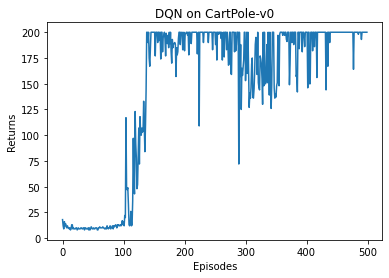

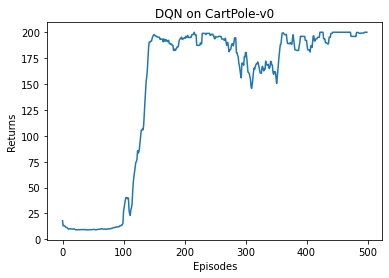

In [7]:
episodes_list = list(range(len(rewards)))
plt.plot(episodes_list, rewards)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(rewards, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

In [8]:
agent.memory.size

10000

In [9]:
agent.epsilon

0.009910645744379363

In [13]:
def test(env, agent ,cfg):
    print("开始测试！")
    print(f"回合：{env_name}, 算法：{cfg.algo_name}, 设备：{cfg.device}")
    rewards = []  # 记录所有回合的奖励
    steps = []
    for i_ep in range(cfg.test_eps):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state = env.reset()  # 重置环境，返回初始状态
        while True:
            ep_step+=1
            action = agent.predict(state)  # 选择动作
            next_state, reward, done, _ = env.step(action)  # 更新环境，返回transition
            state = next_state  # 更新下一个状态
            ep_reward += reward  # 累加奖励
            if done:
                break
        steps.append(ep_step)
        rewards.append(ep_reward)
        print(f'回合：{i_ep+1}/{cfg.test_eps}，奖励：{ep_reward:.2f}')
    print("完成测试")
    env.close()
    return {'rewards':rewards}

test(env, agent, cfg)

开始测试！
回合：CartPole-v0, 算法：DQN, 设备：cpu
回合：1/20，奖励：200.00
回合：2/20，奖励：200.00
回合：3/20，奖励：200.00
回合：4/20，奖励：200.00
回合：5/20，奖励：200.00
回合：6/20，奖励：200.00
回合：7/20，奖励：200.00
回合：8/20，奖励：200.00
回合：9/20，奖励：200.00
回合：10/20，奖励：200.00
回合：11/20，奖励：200.00
回合：12/20，奖励：200.00
回合：13/20，奖励：200.00
回合：14/20，奖励：200.00
回合：15/20，奖励：200.00
回合：16/20，奖励：200.00
回合：17/20，奖励：200.00
回合：18/20，奖励：200.00
回合：19/20，奖励：200.00
回合：20/20，奖励：200.00
完成测试


{'rewards': [200.0,
  200.0,
  200.0,
  200.0,
  200.0,
  200.0,
  200.0,
  200.0,
  200.0,
  200.0,
  200.0,
  200.0,
  200.0,
  200.0,
  200.0,
  200.0,
  200.0,
  200.0,
  200.0,
  200.0]}

在render界面显示


In [16]:
state= env.reset(seed=1)
frames = [] # for animation
while True:
    action = agent.predict(state)  # 选择动作
    next_state, reward, done, _ = env.step(action)  # 更新环境，返回transition
    state = next_state  # 更新下一个状态
    env_screen = np.array(env.render())[0]
    frames.append(env_screen)
    if done:
        break
anim = plot_sequence_images(frames)
rc('animation', html='html5')
anim

<Figure size 600x400 with 0 Axes>